In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
from copy import copy
from pathlib import Path

import cv2
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

from bs4 import BeautifulSoup
from PIL import Image
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

In [ ]:
# MODIFY HERE point to shared data folder
data_path = Path("/content/drive/MyDrive/AI for Damage Inspection shared/01. Data")

In [ ]:
train_path = data_path / "train"
val_path = data_path / "val"

annotation_dir = "Annotations"
images_dir = "Images"

In [ ]:
train_annotations = list((train_path / annotation_dir).glob("*.xml"))

## Deprecated

In [ ]:
def load_xml_string(path):
    """Load xml file as string."""
    with open(path, 'r') as f:
        xml_string = f.read()
    return xml_string

def dictify(r, root = True):
    """Parse xml string into a dictionary.

    Source: https://stackoverflow.com/questions/2148119/how-to-convert-an-xml-string-to-a-dictionary
    
    """
    if root:
        return {r.tag : dictify(r, False)}
    d = copy(r.attrib)
    if r.text:
        val = r.text.replace("\n", "").replace("\t", "").strip()
        if val:
            d["value"] = val
    for x in r.findall("./*"):
        if x.tag not in d:
            d[x.tag] = []
        d[x.tag].append(dictify(x,False))
    return d

def framefy(xml_dict):
    """Turn annotation xml dictionary into a dataframe."""
    base = xml_dict["annotation"]
    row_df = pd.DataFrame(
        {
            "filename": base["filename"][0]["value"],
            "folder": base["folder"][0]["value"],
            "bndbox": [{key: values[0]["value"] for val in base["object"][0]["bndbox"] for key, values in val.items()}],
            "difficult": base["object"][0]["difficult"][0]["value"],
            "name": base["object"][0]["name"][0]["value"],
            "pose": base["object"][0]["pose"][0]["value"],
            "truncated": base["object"][0]["truncated"][0]["value"],
            "path": base["path"][0]["value"],
            "size": [{key: values[0]["value"] for key, values in base["size"][0].items()}],
            "source": base["source"][0]["database"][0]["value"]
        },
    )
    return row_df

def parse_annotations(paths):
    """Load and parse annotations xml into a dataframe."""
    annotations = pd.DataFrame()
    for path in tqdm(paths):
        xml_string = load_xml_string(path)
        root = ET.fromstring(xml_string)
        xml_dict = dictify(root)
        xml_series = framefy(xml_dict)
        annotations = pd.concat([annotations, xml_series])
    return annotations.reset_index(drop=True)

In [ ]:
annotations = parse_annotations(train_annotations)
annotations

  0%|          | 0/716 [00:00<?, ?it/s]

,filename,folder,bndbox,difficult,name,pose,truncated,path,size,source
0,P0079455_11_10.png,drones,"{'xmin': '8', 'ymin': '3', 'xmax': '964', 'yma...",0,asr,Unspecified,0,/computer-vision/drones/raw/Images/P0079455_11...,"{'width': '972', 'height': '729', 'depth': '3'}",Unspecified
1,P0079455_01_12.png,drones,"{'xmin': '3', 'ymin': '6', 'xmax': '972', 'yma...",0,asr,Unspecified,0,/computer-vision/drones/raw/Images/P0079455_01...,"{'width': '972', 'height': '729', 'depth': '3'}",Unspecified
2,P0079434_08_08.png,drones,"{'xmin': '7', 'ymin': '6', 'xmax': '967', 'yma...",0,asr,Unspecified,0,/computer-vision/drones/raw/Images/P0079434_08...,"{'width': '972', 'height': '729', 'depth': '3'}",Unspecified
3,P0079438_02_03.png,drones,"{'xmin': '1', 'ymin': '3', 'xmax': '972', 'yma...",0,asr,Unspecified,0,/computer-vision/drones/raw/Images/P0079438_02...,"{'width': '972', 'height': '729', 'depth': '3'}",Unspecified
4,P0079434_08_03.png,drones,"{'xmin': '16', 'ymin': '57', 'xmax': '953', 'y...",0,asr,Unspecified,0,/computer-vision/drones/raw/Images/P0079434_08...,"{'width': '972', 'height': '729', 'depth': '3'}",Unspecified
...,...,...,...,...,...,...,...,...,...,...
711,DSC03503_01_07.png,drones,"{'xmin': '112', 'ymin': '225', 'xmax': '920', ...",0,scheur,Unspecified,0,/computer-vision/computer-vision/drones/raw/Im...,"{'width': '920', 'height': '614', 'depth': '3'}",Unspecified
712,DSC03501_07_08.png,drones,"{'xmin': '1', 'ymin': '109', 'xmax': '509', 'y...",0,scheur,Unspecified,0,/computer-vision/computer-vision/drones/raw/Im...,"{'width': '920', 'height': '614', 'depth': '3'}",Unspecified
713,DSC03501_06_04.png,drones,"{'xmin': '13', 'ymin': '203', 'xmax': '918', '...",0,scheur,Unspecified,0,/computer-vision/computer-vision/drones/raw/Im...,"{'width': '920', 'height': '614', 'depth': '3'}",Unspecified
714,DSC03501_05_07.png,drones,"{'xmin': '7', 'ymin': '4', 'xmax': '920', 'yma...",0,scheur,Unspecified,0,/computer-vision/computer-vision/drones/raw/Im...,"{'width': '920', 'height': '614', 'depth': '3'}",Unspecified


In [ ]:
annotations["name"].value_counts()

asr         360
scheur      250
betonrot    106
Name: name, dtype: int64

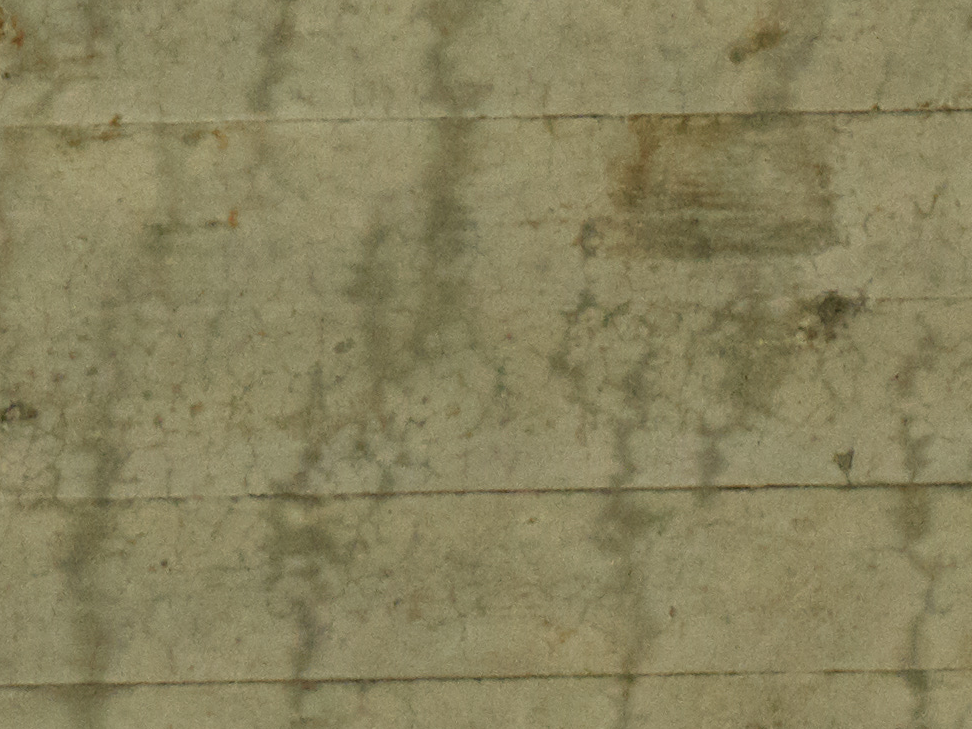

In [ ]:
Image.open(train_path / images_dir / annotations['filename'].iloc[0])

## View samples

In [ ]:
# https://github.com/rmalav15/visualize-voc-format-data
class Entity():
    def __init__(self, name, xmin, xmax, ymin, ymax, difficult, truncated):
        self.name = name
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.difficult = difficult
        self.truncated = truncated


class Data():
    def __init__(self, root_dir, data_type, annotation_name):
        self.annotation_name = annotation_name
        self.annotation_path = root_dir / data_type / "Annotations" / annotation_name
        self.image_path = root_dir / data_type / "Images"
        self.annotations = self.load_annotations()

    def load_annotations(self):
        annotations = []
        xml_content = open(self.annotation_path).read()
        bs = BeautifulSoup(xml_content, 'xml')
        objs = bs.findAll('object')
        self.image_name = bs.findAll("filename")[0].contents[0]
        self.image_path = self.image_path / self.image_name
        for obj in objs:
            obj_name = obj.findChildren('name')[0].text
            difficult = int(obj.findChildren('difficult')[0].contents[0])
            truncated = int(obj.findChildren('truncated')[0].contents[0])
            bbox = obj.findChildren('bndbox')[0]
            xmin = int(bbox.findChildren('xmin')[0].contents[0])
            ymin = int(bbox.findChildren('ymin')[0].contents[0])
            xmax = int(bbox.findChildren('xmax')[0].contents[0])
            ymax = int(bbox.findChildren('ymax')[0].contents[0])
            annotations.append(Entity(obj_name, xmin, xmax, ymin, ymax, difficult, truncated))
        return annotations

In [ ]:
from ipywidgets import interact
%matplotlib inline
import matplotlib.pyplot as plt

class args:
    root_dir = data_path
    data_type = "train"
    random_seed = 42
    save_images = False
    save_dir = "output"
    line_thickness = 2
    with_bbox = True

random.seed(args.random_seed)

def process_image(image_data, with_bbox=False):
    if not os.path.exists(image_data.image_path):
        image_data.image_path=image_data.image_path.replace('jpg', 'png')
    image = cv2.imread(str(image_data.image_path))
    image = cv2.putText(image, image_data.image_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 1)
    if with_bbox:
        for ann in image_data.annotations:
            box_color = (0, 255, 0)  #Green
            if ann.difficult or ann.truncated:
                box_color = (0, 0, 255) #Red
            image = cv2.rectangle(image, (ann.xmin, ann.ymin), (ann.xmax, ann.ymax), box_color, args.line_thickness)
            image = cv2.putText(image, ann.name, (ann.xmin, ann.ymax), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return image

def show_sample(args, annotations, index=None):
    total_annt = len(annotations)
    #print(len(annotations))
    #total_annt = 100
    if index is not None:
        assert index < total_annt
    else:
        index = random.randint(0, total_annt)

    #cv2_imshow(image)
    def view_image(index):
      print(index)
      image_data = Data(args.root_dir, args.data_type, annotations[index])
      image = process_image(image_data, args.with_bbox)
      plt.figure(figsize=(15,15))
      plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
      plt.title('Training: %s' % annotations[index])
      plt.show()
    interact(view_image, index=(0,total_annt-1))

In [ ]:
show_sample(args, train_annotations, index=None)

interactive(children=(IntSlider(value=357, description='index', max=715), Output()), _dom_classes=('widget-int…

# TODO

## Data Exploration
- [ ] Check if there are any multilabel samples (multiple damages in a single image).
- [ ] Modify `framefy` to allow for multilabel instances or make it more generic. The function was implemented as simple as possible and currently only supports data with a single label.
- [ ] Process data from `annotations` dataframe, currently they're mostly objects (strings).
- [ ] Make plotting function to show image + bounding boxes.
- [ ] Explore data distribution and check if it matches the one from the report.
- [ ] More general data exploration.

## Research
- [ ] Read papers from drive folder.
- [ ] Read YOLO v7 paper lightly.
- [ ] Try to run a YOLO v7 template training.

## Baselines
- [ ] BASELINE 1: Implement YOLO v7 tiny or similar.
- [ ] BASELINE 2: Implement YOLO vX (get a stable, clean or easy to use implementation for a rapid baseline evaluation).

## Modeling
- [ ] Get more datasets.